### 펫 인프라 시설 데이터 분석

#### 가설
- 만족도가 높은 인프라시설이 많은 자치구별의 경우 반려동물을 많이 키울것이다.
- 서울시 반려동물 등록건수와 인프라 시설수와의 관계 분석

- 사용 라이브러리 로드

In [74]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import folium
import mysql.connector
import koreanize_matplotlib 
import json

%matplotlib inline

- 데이터 로드

In [75]:
conn = mysql.connector.connect(
    host = "database-2.c3iym8yog7ht.ap-northeast-2.rds.amazonaws.com",
    port = 3306,
    user = "pethub",
    password = "addinedu5",
    database = "pethub"
)

In [76]:
cursor = conn.cursor()
cursor.execute("""
                SELECT l.region, c.type, i.name, r.setiment, i.lat, i.lng
                from review r
                LEFT JOIN pet_infra i ON r.infra_id = i.id
                LEFT JOIN infra_category c ON i.category_id = c.id
                LEFT JOIN region_list l ON i.region_id = l.id;
                """)

result = cursor.fetchall()

infra_reivew_df = pd.DataFrame(result, columns=["region", "type", "name", "setiment", "lat", "lng"])
infra_reivew_df.head()

,region,type,name,setiment,lat,lng
0,은평구,공원,은평구 반려견 놀이터,Y,37.49062,126.919205
1,은평구,공원,은평구 반려견 놀이터,Y,37.49062,126.919205
2,은평구,공원,은평구 반려견 놀이터,Y,37.49062,126.919205
3,은평구,공원,은평구 반려견 놀이터,Y,37.49062,126.919205
4,은평구,공원,은평구 반려견 놀이터,Y,37.49062,126.919205


In [77]:
cursor = conn.cursor()
cursor.execute("""
                SELECT l.region, p.breed, r.count
                from region_pet_regist r
                LEFT JOIN region_list l ON r.region_id = l.id
                LEFT JOIN pet_type p ON r.pet_type_id = p.id;
                """)

result = cursor.fetchall()

regist_df = pd.DataFrame(result, columns=["region", "breed", "pet_count"])
regist_df.head()

,region,breed,pet_count
0,종로구,골든 리트리버,156
1,종로구,그레이 하운드,5
2,종로구,달마시안,3
3,종로구,도베르만,21
4,종로구,라브라도 리트리버,136


In [78]:
cursor = conn.cursor()
cursor.execute("""
                SELECT l.region, c.type, p.name, p.lat, p.lng
                from pet_infra p
                LEFT JOIN infra_category c ON p.category_id = c.id
                LEFT JOIN region_list l ON p.region_id = l.id;
                """)

result = cursor.fetchall()

infra_df = pd.DataFrame(result, columns=["region", "type", "name", "lat", "lng"])
infra_df.head()

,region,type,name,lat,lng
0,은평구,공원,은평구 반려견 놀이터,37.490620,126.919205
1,광진구,공원,어린이대공원,37.549362,127.081810
2,마포구,공원,월드컵공원 반려견놀이터,37.563873,126.893501
3,동작구,공원,보라매공원,37.492680,126.919136
4,서초구,공원,매헌시민의숲,37.470684,127.035599


- 자치구별 시설 리뷰 수 시각화

In [89]:
region_pet_counts = regist_df.groupby('region')['pet_count'].sum().reset_index()

negative_reviews = infra_reivew_df[infra_reivew_df['setiment'] == 'N']
region_negative_counts = negative_reviews.groupby('region').size().reset_index(name='negative_facility_count')

region_total_facility_counts = infra_reivew_df.groupby('region').size().reset_index(name='total_facility_count')

region_few_negative_counts = pd.merge(region_total_facility_counts, region_negative_counts, on='region', how='left')
region_few_negative_counts['few_negative_facility_count'] = (
    region_few_negative_counts['total_facility_count'] - region_few_negative_counts['negative_facility_count'].fillna(0)
)

region_few_negative_counts = region_few_negative_counts[['region', 'few_negative_facility_count']]
merged_data_new = pd.merge(region_few_negative_counts, region_pet_counts, on='region', how='inner')

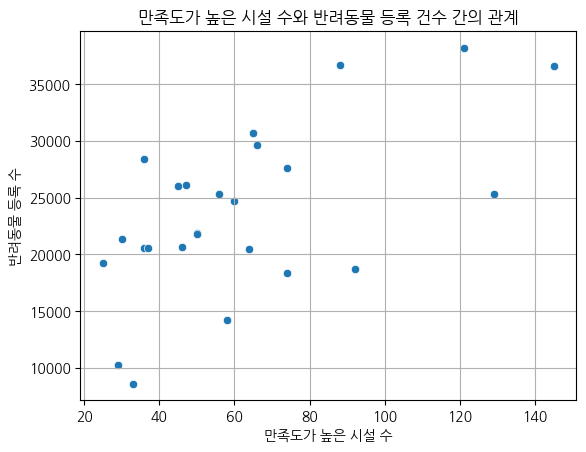

In [80]:
sns.scatterplot(data=merged_data_new, x='few_negative_facility_count', y='pet_count')
plt.title('만족도가 높은 시설 수와 반려동물 등록 건수 간의 관계')
plt.xlabel('만족도가 높은 시설 수')
plt.ylabel('반려동물 등록 수')
plt.grid(True)
plt.show()

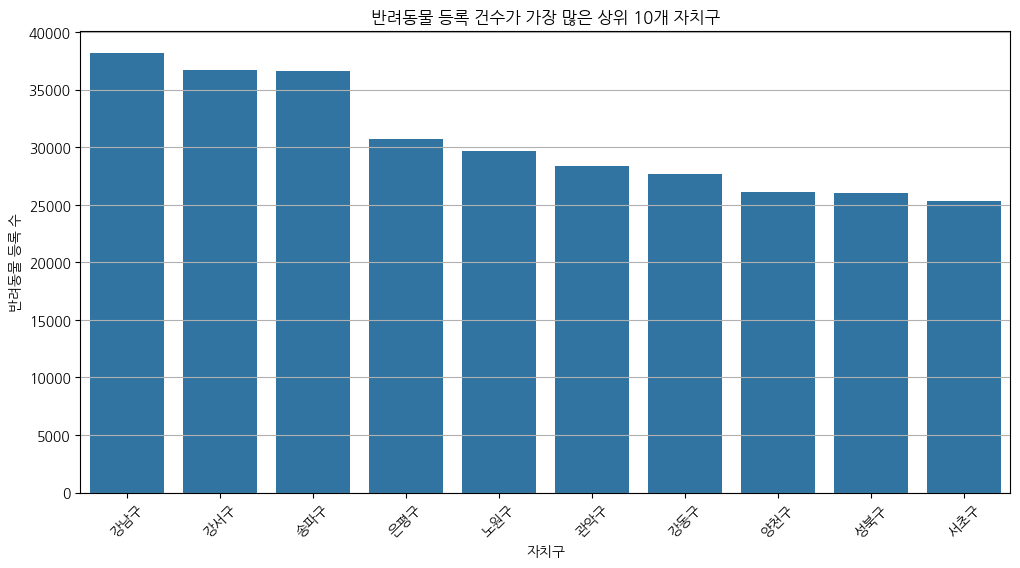

In [81]:
plt.figure(figsize=(12, 6))
top_regions = region_pet_counts.sort_values(by='pet_count', ascending=False).head(10)
sns.barplot(data=top_regions, x='region', y='pet_count')
plt.title('반려동물 등록 건수가 가장 많은 상위 10개 자치구')
plt.xlabel('자치구')
plt.ylabel('반려동물 등록 수')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()

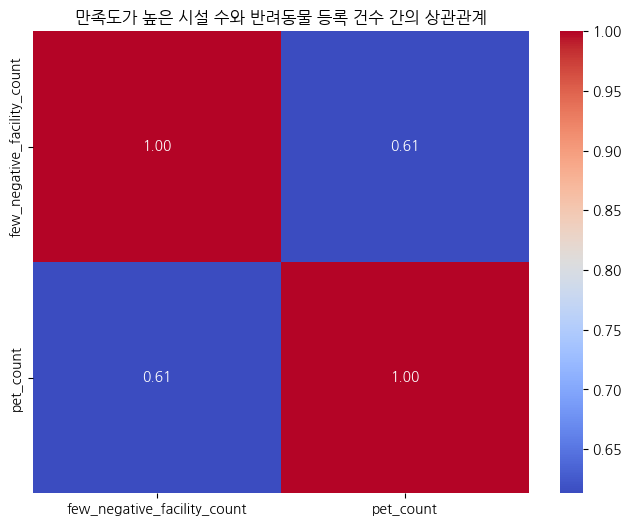

In [82]:
plt.figure(figsize=(8, 6))
correlation_data = merged_data_new[['few_negative_facility_count', 'pet_count']].corr()
sns.heatmap(correlation_data, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('만족도가 높은 시설 수와 반려동물 등록 건수 간의 상관관계')
plt.show()

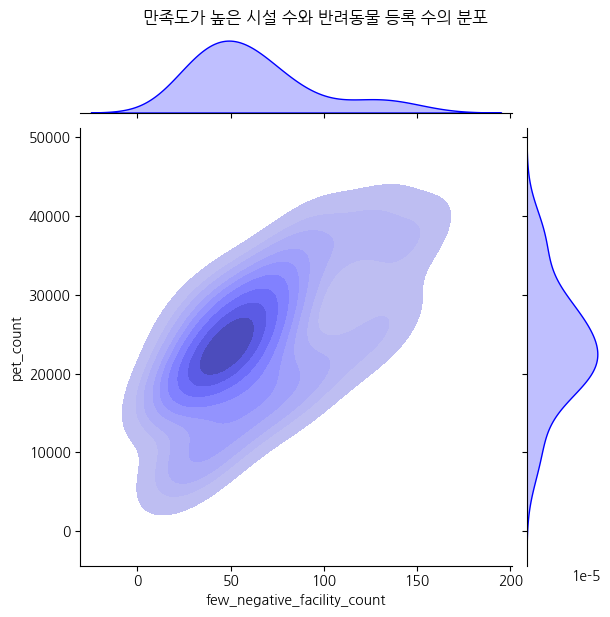

In [83]:
sns.jointplot(
    data=merged_data_new,
    x='few_negative_facility_count',
    y='pet_count',
    kind='kde',
    fill=True,
    color='blue'
)
plt.suptitle('만족도가 높은 시설 수와 반려동물 등록 수의 분포', y=1.02)
plt.show()

- 자치구별 인프라 시설 수 시각화

In [84]:
infra_count = infra_df.groupby('region').size().reset_index(name='infra_count')
pet_count = regist_df.groupby('region')['pet_count'].sum().reset_index()
merged_data = pd.merge(pet_count, infra_count, on='region')

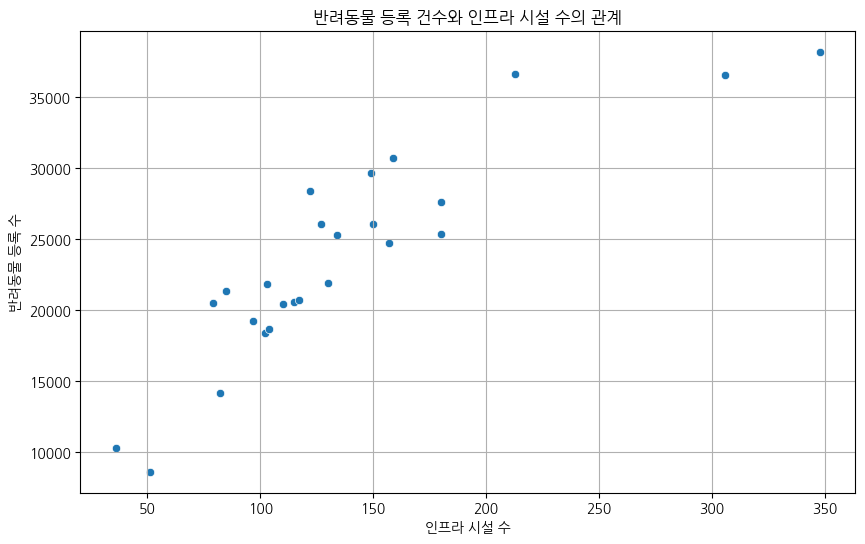

In [85]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=merged_data, x='infra_count', y='pet_count')
plt.title('반려동물 등록 건수와 인프라 시설 수의 관계')
plt.xlabel('인프라 시설 수')
plt.ylabel('반려동물 등록 수')
plt.grid()
plt.show()

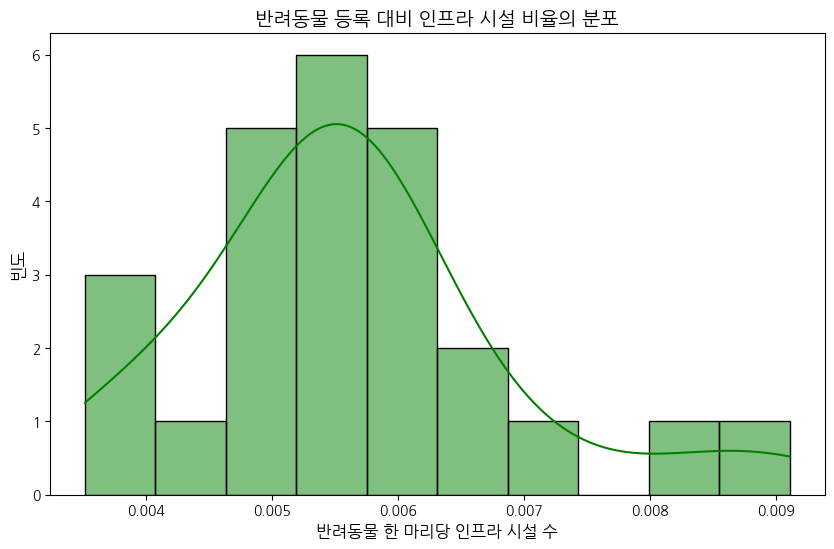

In [86]:
merged_data['infra_per_pet'] = merged_data['infra_count'] / merged_data['pet_count']

plt.figure(figsize=(10, 6))
sns.histplot(merged_data['infra_per_pet'], bins=10, kde=True, color='green')
plt.title('반려동물 등록 대비 인프라 시설 비율의 분포', fontsize=14)
plt.xlabel('반려동물 한 마리당 인프라 시설 수', fontsize=12)
plt.ylabel('빈도', fontsize=12)
plt.show()

/var/folders/1g/mh4r7xrj5gg2lcbjp9rv33fr0000gn/T/ipykernel_4237/1453428423.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=merged_data.sort_values('infra_per_pet', ascending=False), x='region', y='infra_per_pet', palette='viridis')


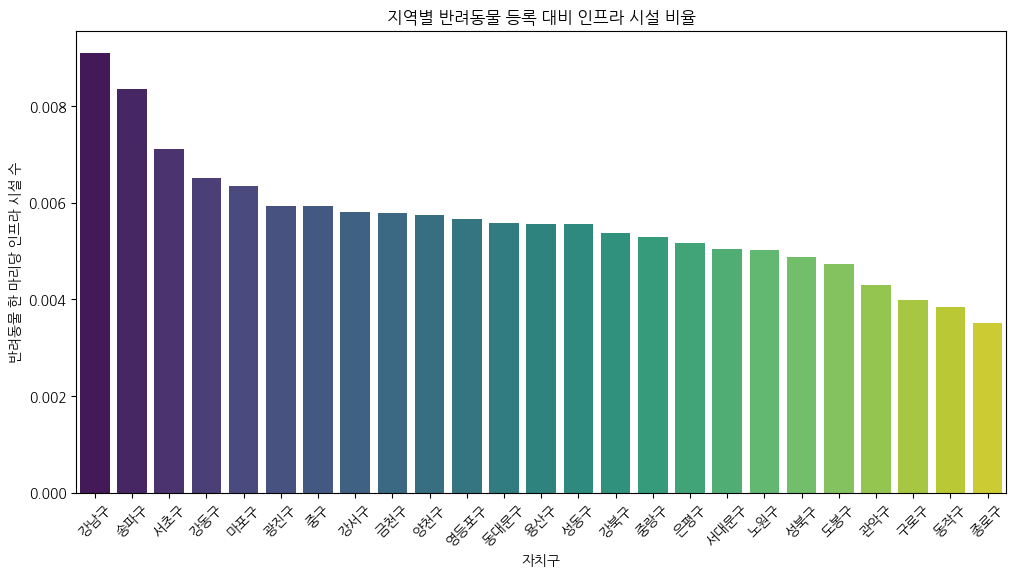

In [87]:
merged_data['infra_per_pet'] = merged_data['infra_count'] / merged_data['pet_count']

plt.figure(figsize=(12, 6))
sns.barplot(data=merged_data.sort_values('infra_per_pet', ascending=False), x='region', y='infra_per_pet', palette='viridis')
plt.title('지역별 반려동물 등록 대비 인프라 시설 비율')
plt.xlabel('자치구')
plt.ylabel('반려동물 한 마리당 인프라 시설 수')
plt.xticks(rotation=45)
plt.show()

/var/folders/1g/mh4r7xrj5gg2lcbjp9rv33fr0000gn/T/ipykernel_4237/2142405464.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_regions, x='region', y='infra_per_pet', palette='muted')


<Figure size 1200x600 with 0 Axes>

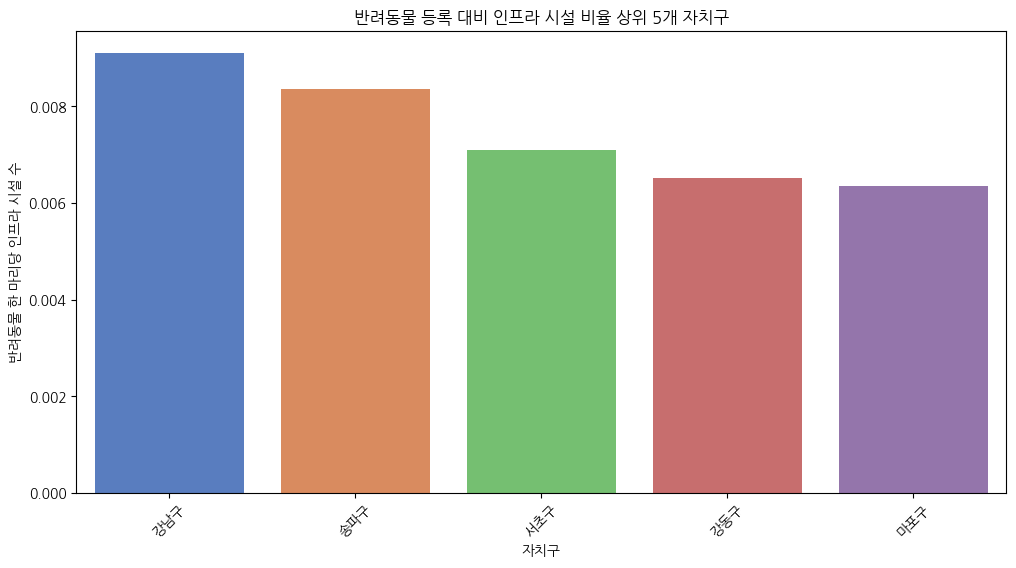

In [ ]:
top_regions = merged_data.sort_values('infra_per_pet', ascending=False).head(5)

plt.figure(figsize=(12, 6))
plt.figure(figsize=(12, 6))
sns.barplot(data=top_regions, x='region', y='infra_per_pet', palette='muted')
plt.title('반려동물 등록 대비 인프라 시설 비율 상위 5개 자치구')
plt.xlabel('자치구')
plt.ylabel('반려동물 한 마리당 인프라 시설 수')
plt.xticks(rotation=45)
plt.show()